In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import time 
from os import listdir
from os.path import join, isfile
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
from PIL import ImageEnhance
import matplotlib.patches as patches
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
%matplotlib inline 

def show(img, figsize=(8, 4), title=None):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.show()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/midterm-testing-numbers/6.jpg
/kaggle/input/midterm-testing-numbers/5.jpg
/kaggle/input/midterm-testing-numbers/8.jpg
/kaggle/input/midterm-testing-numbers/0.jpg
/kaggle/input/midterm-testing-numbers/9.jpg
/kaggle/input/midterm-testing-numbers/1.jpg
/kaggle/input/midterm-testing-numbers/7.jpg
/kaggle/input/midterm-testing-numbers/4.jpg
/kaggle/input/midterm-testing-numbers/3.jpg
/kaggle/input/midterm-testing-numbers/2.jpg


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

# 1. Data preparation
## 1.1 Load data

In [3]:
# Load the data
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

## 1.2 Graph the Distribution of Data

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

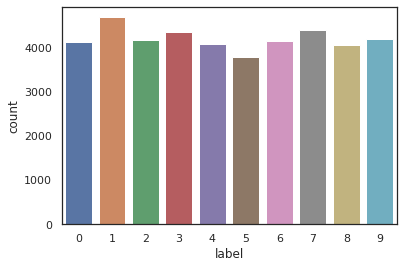

In [4]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

## 1.3 Check for null and missing values

In [5]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

## 1.4 Normalization

Perform a grayscale normalization to reduce the effect of illumination's differences. 


In [7]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [8]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

## 1.5 Label encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

## 1.6 Split training and Validation set 

In [10]:
# Set the random seed
random_seed = 2

In [11]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

## 1.7 Seeing processed images

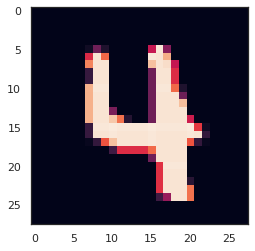

In [12]:
# Random examples of processed imagea 
from random import randint
value = randint(1,100)
g = plt.imshow(X_train[value][:,:,0])

# 2. CNN
## 2.1 Define the model

5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. 


In [13]:
# CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

# Five layers 
# # The first is the convolutional (Conv2D) layer, with 32 filters for the two firsts conv2D layers. Each filter transforms a part
#of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. 
#Filters can be seen as a transformation of the image.
# 'relu' is the rectifier. The rectifier activation function is used to add non linearity to the network. 

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))

# The second is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 
#neighboring pixels and picks the maximal value. These are used to reduce computational cost, and reduce overfitting.
# Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.
model.add(MaxPool2D(pool_size=(2,2)))

# Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero)
#for each training sample. This randomly drops a propotion of the network and forces the network to learn features in a 
#distributed way. This technique also improves generalization and reduces the overfitting. 
model.add(Dropout(0.25))

# Another convolutional 2D layer, with 63 filters for rge last two conv2D layers 
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

# The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed 
#so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local
#features of the previous convolutional layers.
model.add(Flatten())


# Two fully-connected (Dense) layers are used, which are just an artificial neural networks (ANN) classifier. 
#In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

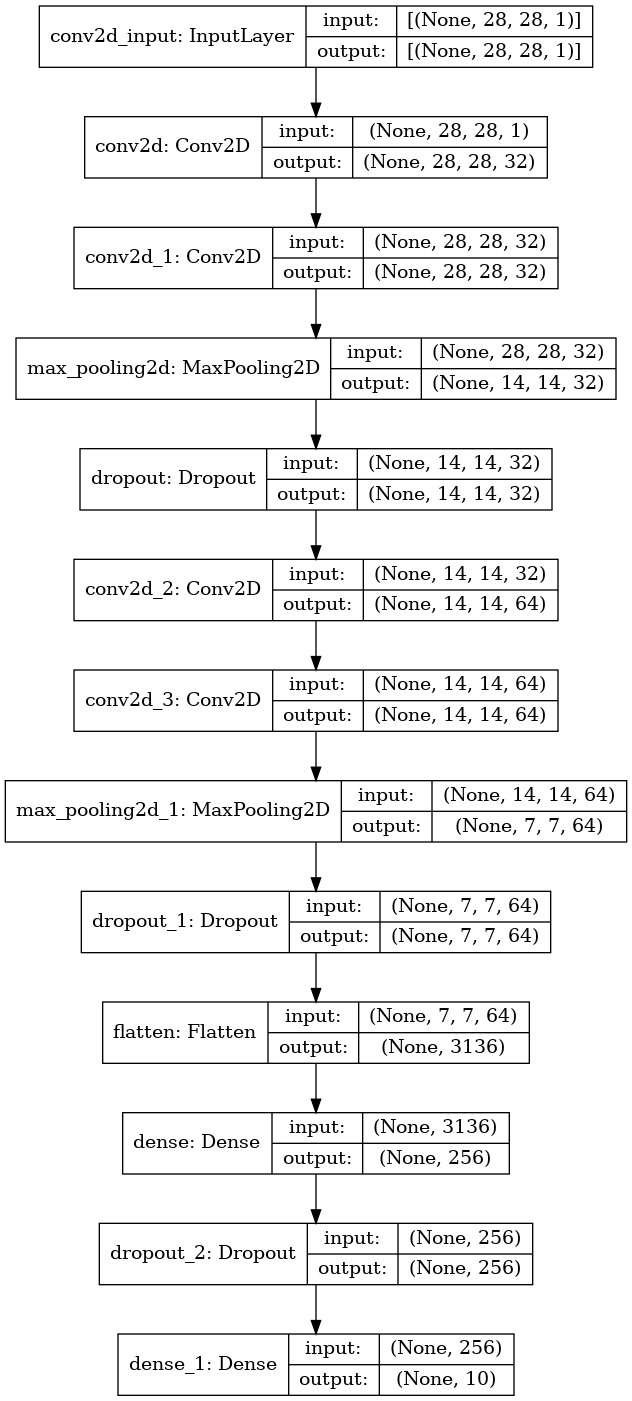

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model.png")

In [15]:
# Define the optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)


In [16]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [17]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [18]:
epochs = 30 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [19]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

#Randomly rotate some training images by 10 degrees
#Randomly Zoom by 10% some training images
#Randomly shift images horizontally by 10% of the width
#Randomly shift images vertically by 10% of the height


In [20]:
# Fit the model
history = model.fit(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])


2022-01-17 22:48:55.462664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
439/439 - 81s - loss: 0.4149 - accuracy: 0.8684 - val_loss: 0.0828 - val_accuracy: 0.9764
Epoch 2/30
439/439 - 79s - loss: 0.1271 - accuracy: 0.9629 - val_loss: 0.0379 - val_accuracy: 0.9900
Epoch 3/30
439/439 - 80s - loss: 0.0941 - accuracy: 0.9713 - val_loss: 0.0417 - val_accuracy: 0.9907
Epoch 4/30
439/439 - 79s - loss: 0.0800 - accuracy: 0.9766 - val_loss: 0.0306 - val_accuracy: 0.9900
Epoch 5/30
439/439 - 80s - loss: 0.0716 - accuracy: 0.9789 - val_loss: 0.0271 - val_accuracy: 0.9905
Epoch 6/30
439/439 - 82s - loss: 0.0668 - accuracy: 0.9806 - val_loss: 0.0233 - val_accuracy: 0.9924
Epoch 7/30
439/439 - 80s - loss: 0.0628 - accuracy: 0.9819 - val_loss: 0.0234 - val_accuracy: 0.9921
Epoch 8/30
439/439 - 79s - loss: 0.0622 - accuracy: 0.9818 - val_loss: 0.0292 - val_accuracy: 0.9931
Epoch 9/30
439/439 - 80s - loss: 0.0612 - accuracy: 0.9822 - val_loss: 0.0196 - val_accuracy: 0.9924
Epoch 10/30
439/439 - 79s - loss: 0.0572 - accuracy: 0.9841 - val_loss: 0.0297 - val_accura

# 3. Evaluate the Model
## 3.1 Training and validation curves

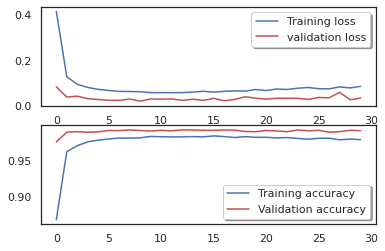

In [21]:
# Draw the loss and accuracy curves of the training set and the validation set.
# Can judge whether it is under-fitting or over-fitting
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## 3.2 Confusion Matrix 

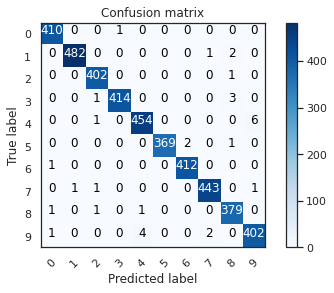

In [22]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

Most common mistake? 

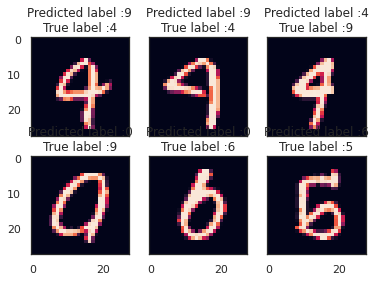

In [23]:
# Display some error results 

errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [24]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")


# 4. Testing 
## 4.1 Predicting hand-written digits after processing of images

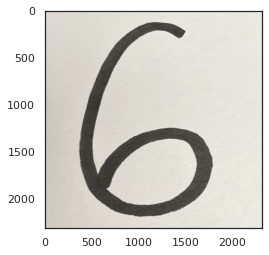

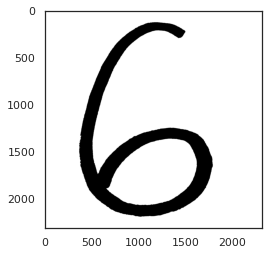

Image details
Size (28, 28)
Mode L


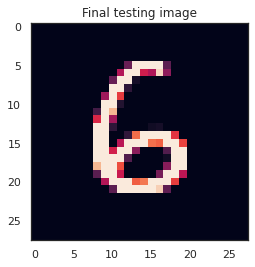




My prediction for ../input/midterm-testing-numbers6.jpg is 6



My prediction was correct!!



Let's Keep Going ! 





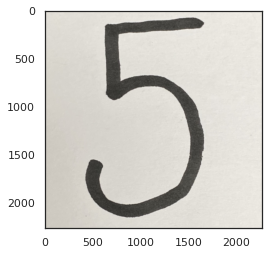

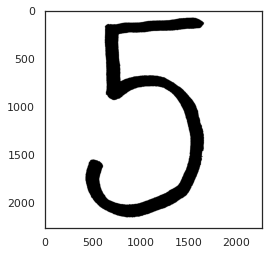

Image details
Size (28, 28)
Mode L


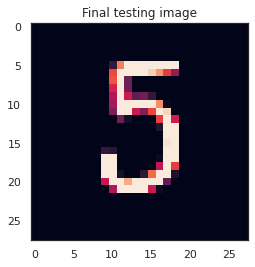




My prediction for ../input/midterm-testing-numbers5.jpg is 5



My prediction was correct!!



Let's Keep Going ! 





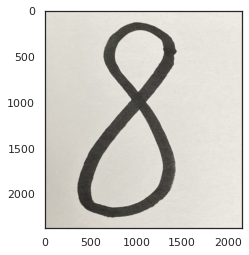

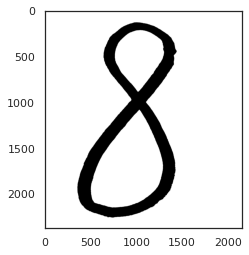

Image details
Size (28, 28)
Mode L


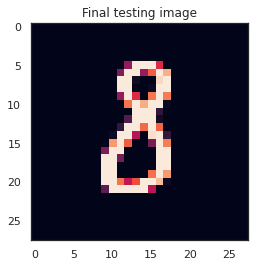




My prediction for ../input/midterm-testing-numbers8.jpg is 8



My prediction was correct!!



Let's Keep Going ! 





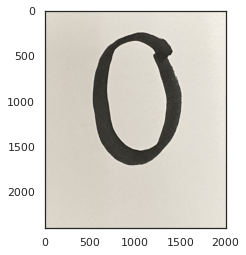

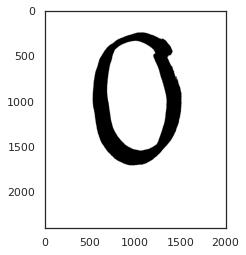

Image details
Size (28, 28)
Mode L


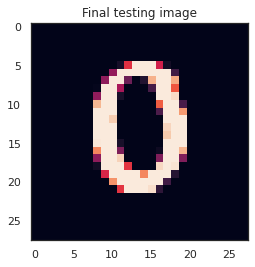




My prediction for ../input/midterm-testing-numbers0.jpg is 0



My prediction was correct!!



Let's Keep Going ! 





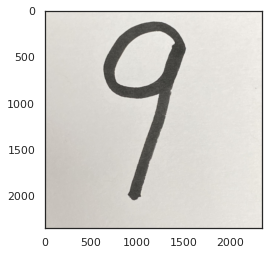

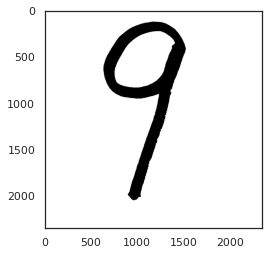

Image details
Size (28, 28)
Mode L


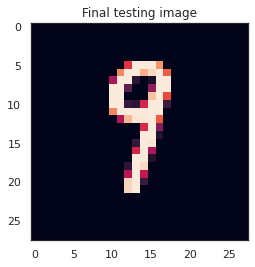




My prediction for ../input/midterm-testing-numbers9.jpg is 9



My prediction was correct!!



Let's Keep Going ! 





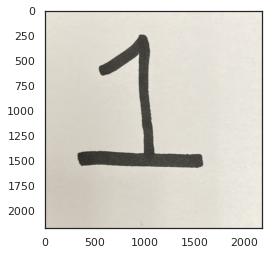

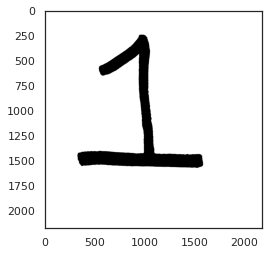

Image details
Size (28, 28)
Mode L


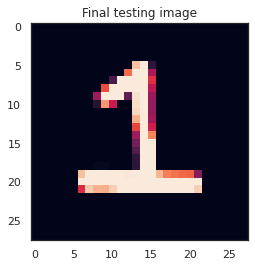




My prediction for ../input/midterm-testing-numbers1.jpg is 1



My prediction was correct!!



Let's Keep Going ! 





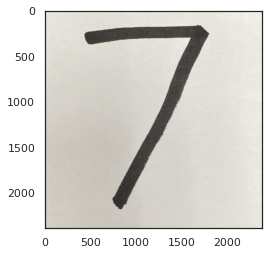

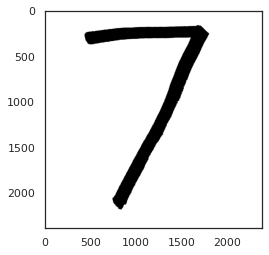

Image details
Size (28, 28)
Mode L


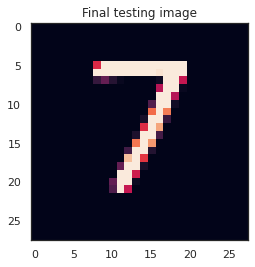




My prediction for ../input/midterm-testing-numbers7.jpg is 7



My prediction was correct!!



Let's Keep Going ! 





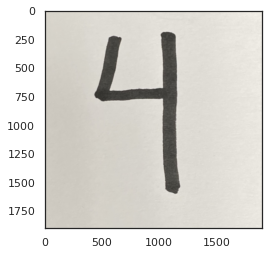

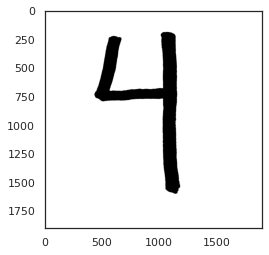

Image details
Size (28, 28)
Mode L


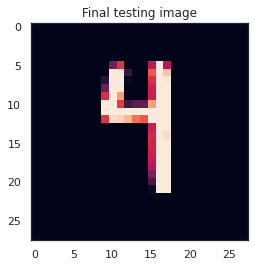




My prediction for ../input/midterm-testing-numbers4.jpg is 4



My prediction was correct!!



Let's Keep Going ! 





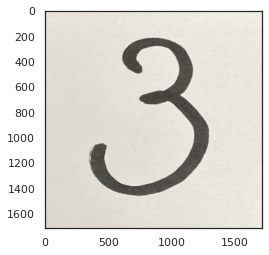

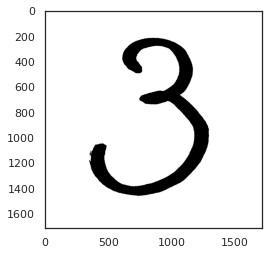

Image details
Size (28, 28)
Mode L


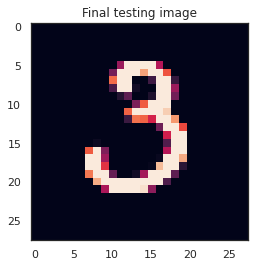




My prediction for ../input/midterm-testing-numbers3.jpg is 3



My prediction was correct!!



Let's Keep Going ! 





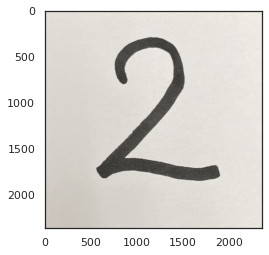

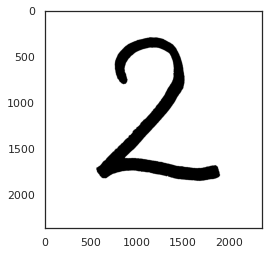

Image details
Size (28, 28)
Mode L


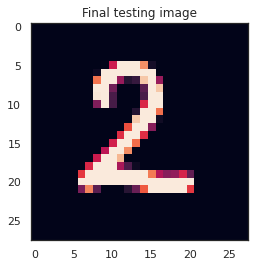




My prediction for ../input/midterm-testing-numbers2.jpg is 2



My prediction was correct!!



Let's Keep Going ! 






 Congrats ! 



Out of 10 you got 10 right!


In [25]:
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter
from PIL import ImageEnhance


count = 0
success = 0
# change this to Mr. Rivero's folder for testing 
input_folder = "../input/midterm-testing-numbers"

for root, dirs, files in os.walk(input_folder):
    for file in files:
             if file.endswith('.jpg') or file.endswith('.png') or file.endswith('.JPEG'):
                actual_num = file[0]
                root = root + "/"
                image_type = file[-2:]
                if image_type == "pg":
                    type_image = ".jpg"
                if image_type == "EG":
                    type_image = ".JPEG"
                if image_type == "ng":
                    type_image = ".png"
                
                # open image 
                image = Image.open(root + actual_num + type_image)
                # blur image 
                image = image.filter(ImageFilter.BLUR)
                # convert image to black and white 
                bw_image = image.convert(mode='L') 
                bw_image = bw_image.convert(mode='1') 
                thresh = 140 
                # turn pixels into white if x is greater than 140, otherwise turn the pixels black 
                fn = lambda x : 255 if x > thresh else 0
                bw_image = image.convert('L').point(fn, mode='1')
                show(image)
                show(bw_image)
                
               # crop the image in case people left a border around their images
                num1 = 17
                num2 = 50
                width, height = bw_image.size
                left = 20
                top = 20
                right = width - 150
                bottom = height - 20

                bw_image = bw_image.crop((left, top, right, bottom))                
                #show(bw_image)
                bw_image.save("bw_image.jpg")
                filename = '../input/digits.png'
                # changed image to image_bw
                image_bw = Image.open("./bw_image.jpg")
                
                # redo the same process to get rid of loose pixels 
                bw_image = image_bw.convert(mode='L') 
                bw_image = bw_image.convert(mode='1') 
                thresh = 140 #140
                fn = lambda x : 255 if x > thresh else 0
                bw_image = image_bw.convert('L').point(fn, mode='1')
                # show(bw_image)
                image_bw = image_bw.convert(mode='L')
   
                width, height = image_bw.size
                if height > width:
                    divider = height / num2
                    height2 = height / divider
                    width2 =  width / divider
                else:
                    divider = width / num2
                    height2 = height / divider
                    width2 =  width / divider
                width2 = round(width2)
                height2 = round(height2)
                
                # resizing to 28x28
                image_bw = image_bw.resize((width2,height2),resample=Image.BILINEAR)
                image_bw = image_bw.resize((width,height),resample=Image.BILINEAR)
                image_bw = ImageEnhance.Contrast(image_bw).enhance(2)
                bw_image = image_bw.convert(mode='L') #L is 8-bit black-and-white image mode
                bw_image = ImageEnhance.Contrast(bw_image).enhance(1.5)
                sample = bw_image
                inv_sample = ImageOps.invert(sample)
                
                # bbox gets the further pixel to the top, bottom, and left and then creates a box around that image 
                bbox = inv_sample.getbbox()
                width, height = sample.size
                inv_sample = ImageOps.invert(sample)
                bbox = inv_sample.getbbox()
                crop = inv_sample.crop(bbox)
                img = crop
                width, height = img.size
                if height > width:
                    divider = height / num1
                    height = height / divider
                    width =  width / divider
                else:
                    divider = width / num1
                    height = height / divider
                    width =  width / divider
                width = round(width)
                height = round(height)
                crop = img.resize((width,height),resample=Image.BILINEAR)
                
                #resize back
                new_size = 28
                new_width = new_size - crop.size[0]
                new_height = new_size - crop.size[1]
                padding = (new_width//2, new_height//2, new_width-(new_width//2), new_height-(new_height//2))
                new_img = ImageOps.expand(crop, padding)
                new_img = ImageEnhance.Contrast(new_img).enhance(2) 
                print(f'Image details')
                print(f'Size {new_img.size}')
                print(f'Mode {new_img.mode}')
                
                show(new_img, title='Final testing image')
                new_img.save("new_img.png")
                
                filename = "./new_img.png"
                img = load_img(filename,color_mode="grayscale", target_size=(28, 28))
                img = img_to_array(img)
                # reshape into a single sample with 1 channel
                img = img.reshape(1, 28, 28, 1)
                # prepare pixel data
                img = img.astype('float32')
                #img = 255.0 - img
                img = img / 255.0 
                
                # predicting
                pred = model.predict(img.reshape(1, 28, 28, 1))
                prediction = pred.argmax()
                image_names = input_folder + actual_num + type_image
                print("\n\n\nMy prediction for " + str(image_names) + " is "+ str(prediction) + "\n\n\n")
                if str(prediction) == str(actual_num):
                    print("My prediction was correct!!")
                    success += 1
                else:
                    print("My prediction was not correct :( ")
                count += 1 
                print("\n\n\nLet's Keep Going ! \n\n\n")
                time.sleep(1)

                
print("\n\n\n Congrats ! \n\n\n")
print("Out of " + str(count) + " you got " + str(success) + " right!")

In [26]:
#acc = input("How many did you get right out of " + str(count) +" : ")

model.save("model_final_midterm.h5")
